In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import itertools

from multiprocessing import Pool
from itertools import product

In [2]:
%run config.py
%run shared.py

In [3]:
valid = pd.read_pickle(PATH_VALID_DEVICES)

# Category ranking

**RQ:** What do users see when they open the notification drawer (or the lock screen)? How many notifications are there and from what kind of apps (categories)?

In [4]:
MAX_POSITIONS = 5

def get_packages_at_positions(lst):
    lst = lst[:MAX_POSITIONS]
    result = []
    for n in lst:
        result.append(n['packageName'])
    result += ['_NONE_' for x in range(MAX_POSITIONS - len(result))]
    return result

def worker_ranking(uuid):
    df = pd.read_pickle('%s%s.pkl.gz' % (PATH_DEVICES_DIR, uuid), compression='gzip')
    df.Active = df.Active.apply(filter_active)
    df.Active = df.Active.apply(get_packages_at_positions)
    
    result = pd.DataFrame(columns=['UUID', 'Position', 'PackageName', 'Percentage'])
    for i in range(MAX_POSITIONS):
        counts = df.Active.apply(lambda x: x[i]).value_counts(dropna=False, normalize=True)
        for index, value in counts.iteritems():
            result = result.append({
                'UUID': uuid,
                'Position': i + 1,
                'PackageName': index,
                'Percentage': value
            }, ignore_index=True)
        
    return result

In [5]:
uuids = valid.UUID.tolist()

p = Pool(NUM_CORES)
lst = p.map(worker_ranking, uuids)

ranking = pd.concat(lst)
ranking = ranking.reset_index(drop=True)

In [6]:
ranking.tail()

,UUID,Position,PackageName,Percentage
427756,device.3952,3,android,0.003061
427757,device.3952,3,com.android.mms,0.001020
427758,device.3952,3,com.android.server.telecom,0.001020
427759,device.3952,4,_NONE_,1.000000
427760,device.3952,5,_NONE_,1.000000


In [7]:
ranking['Category'] = ranking.PackageName.apply(lambda x: category_mapping[x] if x in category_mapping else 'UNKNOWN')
ranking.tail()

,UUID,Position,PackageName,Percentage,Category
427756,device.3952,3,android,0.003061,SYSTEM
427757,device.3952,3,com.android.mms,0.001020,SMS/IM
427758,device.3952,3,com.android.server.telecom,0.001020,PHONE
427759,device.3952,4,_NONE_,1.000000,NONE
427760,device.3952,5,_NONE_,1.000000,NONE


In [8]:
ranking.Category.value_counts()

SYSTEM               92055
TOOL                 49608
UNKNOWN              47816
SMS/IM               41047
MEDIA                39277
SOCIAL               36065
PHONE                22368
NONE                 19612
SHOPPING             17998
GAME                 13940
EMAIL                12478
CALENDAR/REMINDER    11460
NAVIGATION           10987
NEWS                  9486
HEALTH/FITNESS        3564
Name: Category, dtype: int64

## Unknown category

In [9]:
ranking[(ranking.Category == 'UNKNOWN')].PackageName.value_counts().head(10)

package.0095    45
package.0082    42
package.0063    41
package.0050    41
package.0047    41
package.0094    40
package.0043    40
package.0072    40
package.0104    40
package.0083    40
Name: PackageName, dtype: int64

In [10]:
ranking[(ranking.Category == 'UNKNOWN')] \
    .groupby('PackageName') \
    .Percentage.mean() \
    .sort_values(ascending=False) \
    .head(10)

PackageName
package.6163    0.536036
package.7589    0.492343
package.5567    0.483115
package.5269    0.472335
package.5940    0.467033
package.4599    0.405332
package.7037    0.385488
package.7816    0.367729
package.4409    0.325232
package.4753    0.322331
Name: Percentage, dtype: float64

In [11]:
ranking[(ranking.Category == 'UNKNOWN')].PackageName.apply(lambda x: '.'.join(x.split('.')[:4])).value_counts().head(10)

package.0095    45
package.0082    42
package.0063    41
package.0050    41
package.0047    41
package.0094    40
package.0043    40
package.0072    40
package.0104    40
package.0083    40
Name: PackageName, dtype: int64

## Category distribution

In [12]:
ranking.tail()

,UUID,Position,PackageName,Percentage,Category
427756,device.3952,3,android,0.003061,SYSTEM
427757,device.3952,3,com.android.mms,0.001020,SMS/IM
427758,device.3952,3,com.android.server.telecom,0.001020,PHONE
427759,device.3952,4,_NONE_,1.000000,NONE
427760,device.3952,5,_NONE_,1.000000,NONE


In [13]:
ranking2 = pd.DataFrame(list(product(ranking.UUID.unique(), range(1, MAX_POSITIONS + 1))),
             columns=['UUID', 'Position'])

for category in ranking.Category.unique():
    ranking2[category] = pd.Series()

ranking2 = ranking2.set_index(['UUID', 'Position'])
    
ranking2.tail()

NONE  SYSTEM  SMS/IM  PHONE  TOOL  GAME  \
UUID        Position                                            
device.3952 1          NaN     NaN     NaN    NaN   NaN   NaN   
            2          NaN     NaN     NaN    NaN   NaN   NaN   
            3          NaN     NaN     NaN    NaN   NaN   NaN   
            4          NaN     NaN     NaN    NaN   NaN   NaN   
            5          NaN     NaN     NaN    NaN   NaN   NaN   

                      CALENDAR/REMINDER  UNKNOWN  SOCIAL  SHOPPING  \
UUID        Position                                                 
device.3952 1                       NaN      NaN     NaN       NaN   
            2                       NaN      NaN     NaN       NaN   
            3                       NaN      NaN     NaN       NaN   
            4                       NaN      NaN     NaN       NaN   
            5                       NaN      NaN     NaN       NaN   

                      HEALTH/FITNESS  MEDIA  NEWS  NAVIGATION  EMAIL  
UUID        Position                                                  
device.3952 1                    NaN    NaN   NaN         NaN    NaN  
            2                    NaN    NaN   NaN         NaN    NaN  
            3                    NaN    NaN   NaN         NaN    NaN  
            4                    NaN    NaN   NaN         NaN    NaN  
            5                    NaN    NaN   NaN         NaN    NaN

In [14]:
g = ranking.groupby(['UUID', 'Position', 'Category'], as_index=False).sum()
g.tail()

,UUID,Position,Category,Percentage
186434,device.3952,3,PHONE,0.001020
186435,device.3952,3,SMS/IM,0.001020
186436,device.3952,3,SYSTEM,0.003061
186437,device.3952,4,NONE,1.000000
186438,device.3952,5,NONE,1.000000


In [15]:
for index, row in g.iterrows():
    if index % 10000 == 0:
        print(index)
    
    ranking2.loc[(row['UUID'], row['Position']), row['Category']] = row['Percentage']

ranking2.tail()

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000


NONE    SYSTEM    SMS/IM     PHONE      TOOL  GAME  \
UUID        Position                                                           
device.3952 1         0.486735  0.293878  0.128571  0.056122  0.002041   NaN   
            2         0.869388  0.098980  0.016327  0.010204       NaN   NaN   
            3         0.994898  0.003061  0.001020  0.001020       NaN   NaN   
            4         1.000000       NaN       NaN       NaN       NaN   NaN   
            5         1.000000       NaN       NaN       NaN       NaN   NaN   

                      CALENDAR/REMINDER   UNKNOWN  SOCIAL  SHOPPING  \
UUID        Position                                                  
device.3952 1                       NaN  0.014286     NaN       NaN   
            2                       NaN  0.001020     NaN       NaN   
            3                       NaN       NaN     NaN       NaN   
            4                       NaN       NaN     NaN       NaN   
            5                       NaN       NaN     NaN       NaN   

                      HEALTH/FITNESS     MEDIA  NEWS  NAVIGATION  EMAIL  
UUID        Position                                                     
device.3952 1                    NaN  0.018367   NaN         NaN    NaN  
            2                    NaN  0.004082   NaN         NaN    NaN  
            3                    NaN       NaN   NaN         NaN    NaN  
            4                    NaN       NaN   NaN         NaN    NaN  
            5                    NaN       NaN   NaN         NaN    NaN

In [16]:
ranking2 = ranking2.fillna(0)
ranking2 = ranking2.groupby('Position').mean()
ranking2

,NONE,SYSTEM,SMS/IM,PHONE,TOOL,GAME,CALENDAR/REMINDER,UNKNOWN,SOCIAL,SHOPPING,HEALTH/FITNESS,MEDIA,NEWS,NAVIGATION,EMAIL
Position,,,,,,,,,,,,,,,
1,0.219647,0.131091,0.198862,0.050646,0.088665,0.013044,0.011950,0.065951,0.101947,0.008317,0.009639,0.066117,0.011021,0.006028,0.017074
2,0.439091,0.118725,0.074548,0.029987,0.079525,0.013048,0.008810,0.059537,0.086108,0.008151,0.007674,0.038558,0.010336,0.007306,0.018597
3,0.604845,0.088448,0.034488,0.016724,0.062258,0.010494,0.005811,0.046075,0.059070,0.006655,0.005428,0.029922,0.008299,0.006808,0.014675
4,0.717566,0.062133,0.020257,0.010081,0.046794,0.007954,0.003824,0.034265,0.041315,0.005117,0.003978,0.023454,0.006465,0.005907,0.010889
5,0.791614,0.044342,0.013179,0.006334,0.035445,0.006068,0.002528,0.026287,0.031041,0.003848,0.002951,0.018821,0.004823,0.004841,0.007879


In [17]:
ranking2.sum(axis=1)

Position
1    1.0
2    1.0
3    1.0
4    1.0
5    1.0
dtype: float64

In [18]:
ranking2 = ranking2[[
    'PHONE',
    'SMS/IM', 'SOCIAL',
    'EMAIL', 'CALENDAR/REMINDER',
    'SYSTEM', 'TOOL',
    
    'NAVIGATION', 'MEDIA', 'SHOPPING', 'GAME', 'NEWS', 'HEALTH/FITNESS', # 'WEATHER',
    'UNKNOWN', 'NONE'
]]

In [19]:
len(category_mapping)

8824

In [20]:
len(set(category_mapping.values()))

15

## Plot category ranking

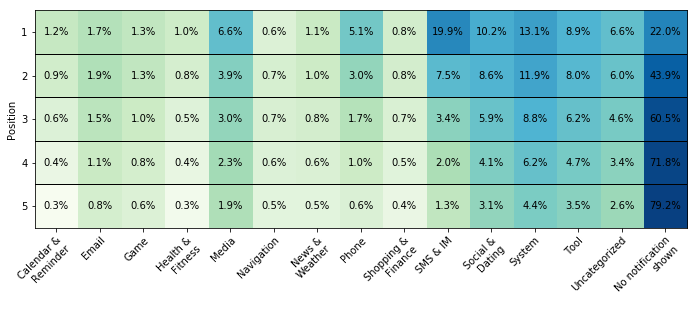

In [21]:
ranking_plot = ranking2.copy()

# Remove capslock from column names
ranking_plot.columns = pd.Series(ranking_plot.columns).apply(str.title).tolist()

# Sort by column name
ranking_plot = ranking_plot.reindex(sorted(ranking_plot.columns[:-2]) + list(ranking_plot.columns[-2:]), axis=1)

# Rename specific columns
ranking_plot = ranking_plot.rename(columns={
    'Shopping': 'Shopping &\nFinance',
    'Calendar/Reminder': 'Calendar &\nReminder',
    'Health/Fitness': 'Health &\nFitness',
    'Sms/Im': 'SMS & IM',
    'Unknown': 'Uncategorized',
    'Social': 'Social &\nDating',
    'None': 'No notification\nshown',
    'News': 'News &\nWeather'
})

fig, ax = plt.subplots(figsize=(12, 4))
im = ax.imshow(np.log(ranking_plot.values), cmap='GnBu') # , vmax=1

# Ticks
ax.set_xticks(range(len(ranking_plot.columns)))
ax.set_yticks(range(len(ranking_plot.index)))

# Tick labels
ax.set_xticklabels(ranking_plot.columns)
ax.set_yticklabels(range(1, 6))

# Rotate labels
plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

# Labels
ax.set_xlabel('', fontsize=10)
ax.set_ylabel('Position', fontsize=10)
ax.tick_params(labelsize=10)

# Values
for i in range(len(ranking_plot.index)):
    for j in range(len(ranking_plot.columns)):
        value = ranking_plot.values[i, j]
        color = 'k' #if value < 0.2 else 'w'
        text = str(np.round(value * 100, 1)) + '%'
        ax.text(j, i, text, ha='center', va='center', color=color, fontsize=10)

ax.set_yticks([x + 0.5 for x in range(0, 5)], minor=True)
ax.grid(which='minor', color='k', linestyle='-', linewidth=1)
ax.tick_params(which='minor', bottom=False, left=False)
    
plt.savefig('figures/category_positions.png', bbox_inches='tight', pad_inches=0, dpi=300)
plt.savefig('figures/category_positions.pdf', bbox_inches='tight', pad_inches=0)

plt.show()

In [22]:
for i in range(0, 5):
    print('Position %s\n-----------------------------' % (i + 1))
    display(ranking2.iloc[i].T.sort_values(ascending=False))
    print('')

Position 1
-----------------------------


NONE                 0.219647
SMS/IM               0.198862
SYSTEM               0.131091
SOCIAL               0.101947
TOOL                 0.088665
MEDIA                0.066117
UNKNOWN              0.065951
PHONE                0.050646
EMAIL                0.017074
GAME                 0.013044
CALENDAR/REMINDER    0.011950
NEWS                 0.011021
HEALTH/FITNESS       0.009639
SHOPPING             0.008317
NAVIGATION           0.006028
Name: 1, dtype: float64


Position 2
-----------------------------


NONE                 0.439091
SYSTEM               0.118725
SOCIAL               0.086108
TOOL                 0.079525
SMS/IM               0.074548
UNKNOWN              0.059537
MEDIA                0.038558
PHONE                0.029987
EMAIL                0.018597
GAME                 0.013048
NEWS                 0.010336
CALENDAR/REMINDER    0.008810
SHOPPING             0.008151
HEALTH/FITNESS       0.007674
NAVIGATION           0.007306
Name: 2, dtype: float64


Position 3
-----------------------------


NONE                 0.604845
SYSTEM               0.088448
TOOL                 0.062258
SOCIAL               0.059070
UNKNOWN              0.046075
SMS/IM               0.034488
MEDIA                0.029922
PHONE                0.016724
EMAIL                0.014675
GAME                 0.010494
NEWS                 0.008299
NAVIGATION           0.006808
SHOPPING             0.006655
CALENDAR/REMINDER    0.005811
HEALTH/FITNESS       0.005428
Name: 3, dtype: float64


Position 4
-----------------------------


NONE                 0.717566
SYSTEM               0.062133
TOOL                 0.046794
SOCIAL               0.041315
UNKNOWN              0.034265
MEDIA                0.023454
SMS/IM               0.020257
EMAIL                0.010889
PHONE                0.010081
GAME                 0.007954
NEWS                 0.006465
NAVIGATION           0.005907
SHOPPING             0.005117
HEALTH/FITNESS       0.003978
CALENDAR/REMINDER    0.003824
Name: 4, dtype: float64


Position 5
-----------------------------


NONE                 0.791614
SYSTEM               0.044342
TOOL                 0.035445
SOCIAL               0.031041
UNKNOWN              0.026287
MEDIA                0.018821
SMS/IM               0.013179
EMAIL                0.007879
PHONE                0.006334
GAME                 0.006068
NAVIGATION           0.004841
NEWS                 0.004823
SHOPPING             0.003848
HEALTH/FITNESS       0.002951
CALENDAR/REMINDER    0.002528
Name: 5, dtype: float64

In [23]:
test = ranking2.copy()
del test['NONE']

for index in test.index:
    print('%s: %s' % (index, test.loc[index].T.sort_values(ascending=False).index.tolist()[:5]))

1: ['SMS/IM', 'SYSTEM', 'SOCIAL', 'TOOL', 'MEDIA']
2: ['SYSTEM', 'SOCIAL', 'TOOL', 'SMS/IM', 'UNKNOWN']
3: ['SYSTEM', 'TOOL', 'SOCIAL', 'UNKNOWN', 'SMS/IM']
4: ['SYSTEM', 'TOOL', 'SOCIAL', 'UNKNOWN', 'MEDIA']
5: ['SYSTEM', 'TOOL', 'SOCIAL', 'UNKNOWN', 'MEDIA']


## Category counts

In [24]:
category_counts = pd.Series(list(category_mapping.values())).value_counts()
category_counts

UNKNOWN              7915
TOOL                  190
MEDIA                 150
SHOPPING              127
GAME                  111
SYSTEM                 94
NEWS                   48
SMS/IM                 45
SOCIAL                 40
HEALTH/FITNESS         24
NAVIGATION             24
CALENDAR/REMINDER      23
PHONE                  18
EMAIL                  14
NONE                    1
dtype: int64

In [25]:
category_counts_2 = category_counts[(category_counts.index != 'NONE')] # & (category_counts.index != 'UNKNOWN')
category_counts_2 = pd.DataFrame(category_counts_2)

category_counts_2['Category'] = category_counts_2.index
category_counts_2 = category_counts_2.rename(columns={
    0: 'Count'
})
category_counts_2 = category_counts_2.reset_index(drop=True)

category_counts_2

,Count,Category
0,7915,UNKNOWN
1,190,TOOL
2,150,MEDIA
3,127,SHOPPING
4,111,GAME
5,94,SYSTEM
6,48,NEWS
7,45,SMS/IM
8,40,SOCIAL
9,24,HEALTH/FITNESS


In [26]:
len(category_counts_2)

14

In [27]:
category_counts_2.Category = category_counts_2.Category.apply(str.title)
category_counts_2 = category_counts_2.sort_values('Category', ascending=True)

category_counts_2.Category = category_counts_2.Category.replace({
    'Shopping': 'Shopping & Finance',
    'Calendar/Reminder': 'Calendar & Reminder',
    'Health/Fitness': 'Health & Fitness',
    'Sms/Im': 'SMS & IM',
    'Unknown': 'Uncategorized',
    'Social': 'Social & Dating',
    'None': 'No notification shown'
})

category_counts_2

,Count,Category
11,23,Calendar & Reminder
13,14,Email
4,111,Game
9,24,Health & Fitness
2,150,Media
10,24,Navigation
6,48,News
12,18,Phone
3,127,Shopping & Finance
7,45,SMS & IM


In [28]:
print(category_counts_2[['Category', 'Count']].to_latex(index=False))

\begin{tabular}{lr}
\toprule
            Category &  Count \\
\midrule
 Calendar \& Reminder &     23 \\
               Email &     14 \\
                Game &    111 \\
    Health \& Fitness &     24 \\
               Media &    150 \\
          Navigation &     24 \\
                News &     48 \\
               Phone &     18 \\
  Shopping \& Finance &    127 \\
            SMS \& IM &     45 \\
     Social \& Dating &     40 \\
              System &     94 \\
                Tool &    190 \\
       Uncategorized &   7915 \\
\bottomrule
\end{tabular}



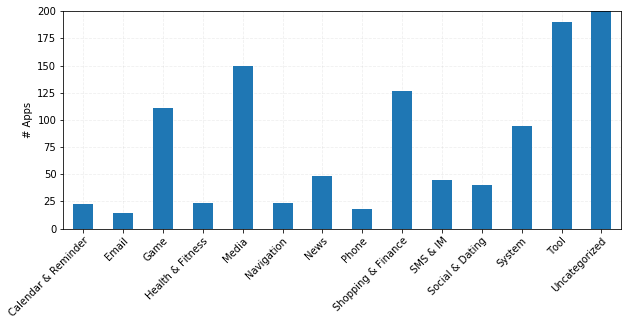

In [29]:
ax = category_counts_2.plot(
    kind='bar',
    x='Category',
    y='Count',
    ylim=(0, 200),
    figsize=(10, 4),
    legend=False,
    grid=True
)

# Grid
ax.set_axisbelow(True)
ax.xaxis.grid(alpha=0.2, linestyle='dashed')
ax.yaxis.grid(alpha=0.2, linestyle='dashed')

# Tweak font sizes
ax.set_xlabel('', fontsize=10)
ax.set_ylabel('# Apps', fontsize=10)
ax.tick_params(labelsize=10)


# Rotate labels
plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

#plt.savefig('figures/category_counts.png', bbox_inches='tight', pad_inches=0, dpi=300)
#plt.savefig('figures/category_counts.pdf', bbox_inches='tight', pad_inches=0)

plt.show()